# Project 1 Fitting Model to the data
 This project is a part of PSI2023 Numerical Method course coordinate by Eric and Dustin. Further reading [Data analysis recipes: Fitting a model to data](arXiv:1008.4686v1). This code works on Julia 1.8.5 `(lastest updated 03/16/23)`
***

## (Q1) Linear & quadratic fitting
<div class="alert alert-block alert-info">
<b>In this section, we will investigate things in the following:</b> 
<br>  
</div>   

1. Does the quadratic fitting better than linear fitting?
2. Jackknife analysis and scatter of parameters.
3. Do we need the q term for a good fit?



### Import data
First, we import the data.csv (popular file type for data analysis).

In [1]:
#Import data
#] add CSV #(remove `#` from `#]` and run only the first time to add CSV)
#] add DataFrames #(remove `#` from `#]` and run only the first time to add DataFrames)
#import Pkg; Pkg.add("WGLMakie") #(remove `#` from `#]` and run only the first time to install WGLMakie which is the Pkg for visualization)
using CSV 
using DataFrames 
alldata = CSV.read("data.csv", DataFrame); #recall the data
data = alldata[5:end, :]; #use data from 5 to the end(20)--note that the index in julia begin from 1 which is different from python that begin from 0

We can play around with the data, such as length of data `size(data)`, recall only column x `data.x`.

Let's see the visualization of the data

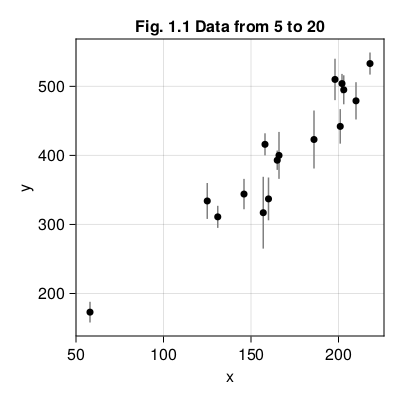

In [2]:
#Plotting
using CairoMakie
f = Figure(resolution = (400,400))
Axis(f[1, 1], title = "Fig. 1.1 Data from 5 to 20", xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y, color=:gray)
scatter!(data.x, data.y, markersize=10, color=:black)
f

Given these data, our task is to find the best fit. Which model is the most suitable for this case? Linear model? Quadatic model? Let's find out!

### Linear model

Appearently, the data set can be fitted by linear equation,
\begin{equation}
ŷ = mx+b.
\end{equation}
$x$ is the data that we have and $ŷ$ is the result from the model given $b$ and $m$. Our task is finding the optimal values of slope ($m$) and $y$-intercept ($b$). This is the task of "fitting model to the data"

Note that the optimal values in this context refer to the values that gives us the minimum of cost function, roughly speaking we get $ŷ$ 'close' to $y$ as much as possible from minimum of cost function. 

The cost function, in general, is some function which defines the 'close'  of our model ($ŷ$) to the data ($y$). 

- Example of cost function: sum of absolute difference of each data point `function costlin_abs(parameters)` and sum of Gaussian negative loglikelihood `function costlin_gauss(parameters)`(it also take σ into account).



In [3]:
#Example of cost functions for linear model
#Sum of absolute difference
function Costlin_abs(parameters, data) #no sigma involved
    b = parameters[1]
    m = parameters[2]
    x = data.x
    y = data.y
    y_pred = b .+ m .* x
    return sum(abs.(y .- y_pred))
end

#Sum of negative log-likelihood
function Costlin_gauss(parameters, data) #sigma included
    b = parameters[1]
    m = parameters[2]
    x = data.x
    y = data.y
    sigma = data.sigma_y
    y_pred = b .+ m .* x
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end;

- In order to minimize the cost function, we use `Opitim` Pkg.

In [4]:
#Minimizing cost function
#] add Optim #(remove `#` from `#]` and run only the first time to add Optim

#Recall Pkg
using Optim

#Define Min function for cost function optimization
function Min(cost, initial_params, data)
    "Min is a function for minimizing cost function. 
    Input: cost, initial_params, data. 
    For example, Min(Costlin_gauss, [initial_param1, initial_param2,...,initial_paramn], CSV.read('data.csv', DataFrame))
    Output: [opt_param1, opt_param2, ..., opt_paramn, final cost function value]"
    result = optimize(p -> cost(p, data), initial_params)
    @assert Optim.converged(result)
    return append!(Optim.minimizer(result),Optim.minimum(result))
end

#Example in our case, optimal values by 2 types of cost function
#initializer
b_0, m_0 = 50., 2. 
initial_lin = [b_0, m_0];

b_abs, m_abs, mincost_abs = Min(Costlin_abs, initial_lin, data)
b_gauss, m_gauss, mincost_gauss = Min(Costlin_gauss, initial_lin, data);

Because we want to take sigma into account for our analysis, after this subsection we will only use negative loglikelihood as the cost function.

- Next, let consider the quadratic model

### Quadratic model

Alternatively, we can use higher-order fit to fit the data. We will consider the quadratic model,
\begin{equation}
    ŷ = qx^{2} +mx+b.
\end{equation}

The idea is the same as the linear fit, but we now have to find the optimal of three values: q, m ,and b.

In [5]:
#The example of cost function for quadratic fiiting
function Costquad_gauss(parameters, data) #sigma included
    b = parameters[1]
    m = parameters[2]
    q = parameters[3]
    x = data.x
    y = data.y
    sigma = data.sigma_y
    y_pred = b .+ m .* x + q .* x .^2
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end;

### Comparison
Let's compare between linear and quadratic fiiting. Which one is better? 

In [6]:
#initializer
b_0, m_0, q_0 = 50., 2., 0. 
initial_lin = [b_0, m_0] #linear model use 2 params
initial_quad = [b_0, m_0, q_0]; #quadrtic use 3 params

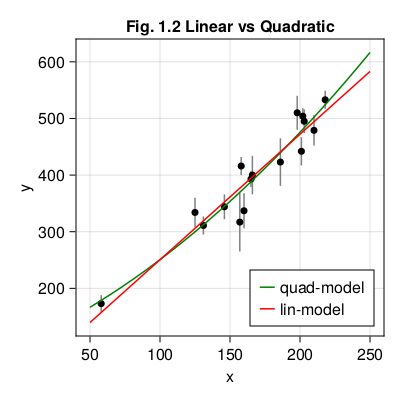

In [7]:
#Optimal value from both types model
b_lin, m_lin, mincost_lin = Min(Costlin_gauss,initial_lin,data) #linear model
b_quad, m_quad, q_quad, mincost_quad = Min(Costquad_gauss, initial_quad, data) #quadratic model

#Plotting Linear vs Quadratic models
f = Figure(resolution=(400,400))
xx = LinRange(50, 250, 25)
Axis(f[1, 1], title = "Fig. 1.2 Linear vs Quadratic", xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y, color = :gray)
scatter!(data.x, data.y, markersize = 10, color = :black)
lines!(xx, b_quad .+ m_quad .* xx .+ q_quad .* xx .^2, color=:green, label = "quad-model")
lines!(xx, b_lin .+ m_lin .* xx, color=:red, label = "lin-model")
axislegend(position = :rb, patchsize = (15,15))
f

Here we go! It looks quad-model better than lin-model in the sense of taking the fluctuation of data into account. However, let's check at the minimum cost function from both model.

In [8]:
#Define function for the different of different model
function Costdiff(mincost1, mincost2)
    return mincost1-mincost2
end

#Save previous minimized cost function
MCQ1= mincost_quad #final cost function from quad model
MCL1= mincost_lin #final cost function from lin model

Costdiff(MCQ1,MCL1)

-0.41923912741253844

Hoolayy! It means that minimized cost function from quadratic model  `mincost_quad` reach lower than linear model`mincost_lin`. Quadratic model makes improvement!

- Let's investigate more example which consider different initial values.

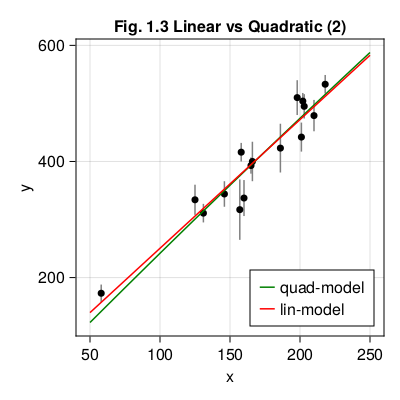

In [9]:
#new initializer
b_0, m_0, q_0 = 0., 0., 0. 
initial_lin_n = [b_0, m_0] #linear model use 2 params
initial_quad_n = [b_0, m_0, q_0] #quadrtic use 3 params
b_quad, m_quad, q_quad, mincost_quad = Min(Costquad_gauss, initial_quad_n, data)
b_lin, m_lin, mincost_lin = Min(Costlin_gauss,initial_lin_n, data)

#Save current minimized cost function
MCQ2 = mincost_quad
MCL2 = mincost_lin

f = Figure(resolution=(400,400))
xx = LinRange(50, 250, 25)
Axis(f[1, 1], title = "Fig. 1.3 Linear vs Quadratic (2)", xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y, color = :gray)
scatter!(data.x, data.y, markersize = 10, color = :black)
lines!(xx, b_quad .+ m_quad .* xx .+ q_quad .* xx .^2, color=:green, label = "quad-model")
lines!(xx, b_lin .+ m_lin .* xx, color=:red, label = "lin-model")
axislegend(position = :rb, patchsize = (15,15))
f


It looks different! What happens? Let's see the cost difference.

In [10]:
Costdiff(MCQ2,MCL2)

0.21749501941303606

The new initialization shows that this time linear model is better! What's going on? Let's check the values from each case.



In [11]:
println("Quad2 = ",MCQ2,",\nQuad2 = ",MCQ1,",\nLin2 = ",MCL2,",\nLin1 = ",MCL1)

Quad2 = 1044.6430064008825,
Quad2 = 1044.0062722479615,
Lin2 = 1044.4255113814695,
Lin1 = 1044.425511375374


We can see that MCQ2>MCQ1 but MCL2=MCL1.



<div class="alert alert-block alert-success">
<b>Notice:</b> Quad-model is more sensitive to an initial value (more precisely, it means that fitting with quad-model is possible to get stuck in local minima with this algorithm). However, we have to explore more initial values. One suggestion is random initialization. 
<br>   
The result here is consistent with our intuition. Quad-model has more parameter so it should fit better (reach lower minimum of the cost function).
</div>

### Jackknife analysis

Jackknife is one of the methods for estimating the uncertainties of the data set when we dont't know or don't believe it. 

This method study the changing of $b,m$ if one data point, $i$, is removed. We get the N (total dataset) set of $b_i,m_i$ which $i$ run from 1 to N. Then the uncerntainties from jackknife method can be calculated by

\begin{equation}
{\tilde{\sigma}}^2=\frac{N-1}{N}\sum_{i=1}^N(m_i-\bar{m})^2.
\end{equation}

- Let's consider Jack-Knief Analysis for Quadratic model

In [12]:
#Define function for Jack-knife whihch is generalized to quadratic model (included q term)
function JK(cost, data, params)
    ndata = size(data,1)
    B_jack = zeros(ndata)
    M_jack = zeros(ndata)
    Q_jack = zeros(ndata)
    
    #Create N data set which each set is removed the sample order i^{th}
    for i in 1:ndata
        xcopy = copy(data.x)
        deleteat!(xcopy, i)
        ycopy = copy(data.y)
        deleteat!(ycopy, i)
        scopy = copy(data.sigma_y)
        deleteat!(scopy, i)

        copydata = DataFrame(x=xcopy,y=ycopy,sigma_y=scopy)
        b_0 = params[1]
        m_0 = params[2]
        q_0 = params[3]
        starting_params = [b_0 + 0., m_0, q_0]
        
        b_jack, m_jack, q_jack = Min(cost, starting_params, copydata)

        B_jack[i] = b_jack
        M_jack[i] = m_jack
        Q_jack[i] = q_jack
    end
    return B_jack, M_jack, Q_jack
end;

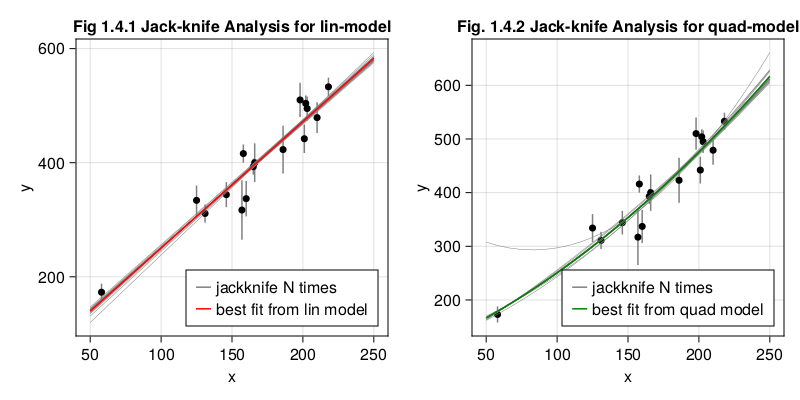

In [13]:
#Plot result from Jackknife
f = Figure(resolution=(800,400))

#initialize
b_0, m_0, q_0 = 50., 2., 0.;
params = [b_0,m_0, q_0]

xx = LinRange(50, 250, 25)


#Jackknife of line model
Axis(f[1, 1], title = "Fig 1.4.1 Jack-knife Analysis for lin-model", xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y, color =:gray)
scatter!(data.x, data.y, markersize = 10, color = :black)
Blin_jack, Mlin_jack, Qlin_jack = JK(Costlin_gauss, data, params)
ndata = size(data,1)
for i in 1:ndata
    yy_jack = xx .* Mlin_jack[i] .+ Blin_jack[i]
    lines!(xx, yy_jack,linewidth=0.5, color=:gray)
end
yy_jack = xx .* Mlin_jack[1] .+ Blin_jack[1]
lines!(xx, yy_jack ,linewidth=1.5, color=:gray, label ="jackknife N times")
b_lin, m_lin, dummy, mincost_lin = Min(Costlin_gauss, initial_quad, data)
yy_lin = xx .* m_lin .+ b_lin
lines!(xx, yy_lin, color=:red, linewidth=1.5, label ="best fit from lin model")
axislegend(position = :rb, patchsize = (15,15))

#Jackknife of quad model
Axis(f[1, 2], title = "Fig. 1.4.2 Jack-knife Analysis for quad-model", xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y, color =:gray)
scatter!(data.x, data.y, markersize = 10, color = :black)
Bquad_jack, Mquad_jack, Qquad_jack = JK(Costquad_gauss, data, params)
ndata = size(data,1)
for i in 1:ndata
    yy_jack = xx.^2 .* Qquad_jack[i] .+ xx .* Mquad_jack[i] .+ Bquad_jack[i]
    lines!(xx, yy_jack,linewidth=0.5, color=:gray)
end
yy_jack = xx.^2 .* Qquad_jack[1] .+ xx .* Mquad_jack[1] .+ Bquad_jack[1]
lines!(xx, yy_jack ,linewidth=1.5, color=:gray, label ="jackknife N times")

b_quad, m_quad, q_quad, mincost_quad = Min(Costquad_gauss, initial_quad, data)
yy_quad = xx.^2 .* q_quad .+ xx .* m_quad .+ b_quad
lines!(xx, yy_quad, color=:green, linewidth=1.5, label ="best fit from quad model")
axislegend(position = :rb, patchsize = (15,15))
f

<a id="F1.5.1"></a>
- Let's investigate the scatter of q values

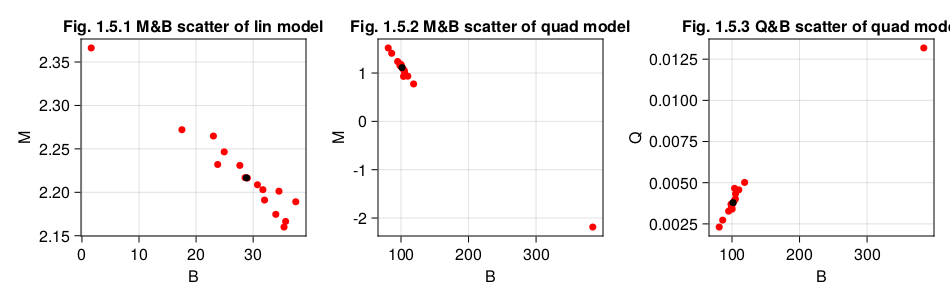

In [14]:
#Q&M and Q&B planes
f = Figure(resolution =(950,300))
Axis(f[1, 1], xlabel = "B", ylabel = "M", title = "Fig. 1.5.1 M&B scatter of lin model")
scatter!(Blin_jack, Mlin_jack, markersize=10, color=:red)
plot!([b_lin], [m_lin], markersize=10)
Axis(f[1, 2], xlabel = "B", ylabel = "M", title = "Fig. 1.5.2 M&B scatter of quad model")
scatter!(Bquad_jack, Mquad_jack, markersize=10, color=:red)
plot!([b_quad], [m_quad], markersize=10)
Axis(f[1, 3], xlabel = "B", ylabel = "Q", title = "Fig. 1.5.3 Q&B scatter of quad model")
scatter!(Bquad_jack, Qquad_jack, markersize=10, color=:red)
plot!([b_quad], [q_quad], markersize=10)

f

We can see that the scatter of q values (and also m) from jackknife method is not lie on the best fit one which means the quadratic model is not suitable with data because it is too sensitive (removing one data can entirely change the best-fit curve). Linear model would be likely a generative model of this data. 

- Finally, we will examine the uncertainties obtained by jackknife method

In [15]:
using Statistics

In [16]:
#Calculate error of b&m from jackknife analysis
B_mean_lin_jack, B_std_lin_jack = mean(Blin_jack), std(Blin_jack) .* sqrt((ndata - 1) / ndata)
M_mean_lin_jack, M_std_lin_jack = mean(Mlin_jack), std(Mlin_jack) .* sqrt((ndata - 1) / ndata)
Q_mean_quad_jack, Q_std_quad_jack = mean(Qquad_jack), std(Qquad_jack) .* sqrt((ndata - 1) / ndata)
B_mean_quad_jack, B_std_quad_jack = mean(Bquad_jack), std(Bquad_jack) .* sqrt((ndata - 1) / ndata)
M_mean_quad_jack, M_std_quad_jack = mean(Mquad_jack), std(Mquad_jack) .* sqrt((ndata - 1) / ndata);

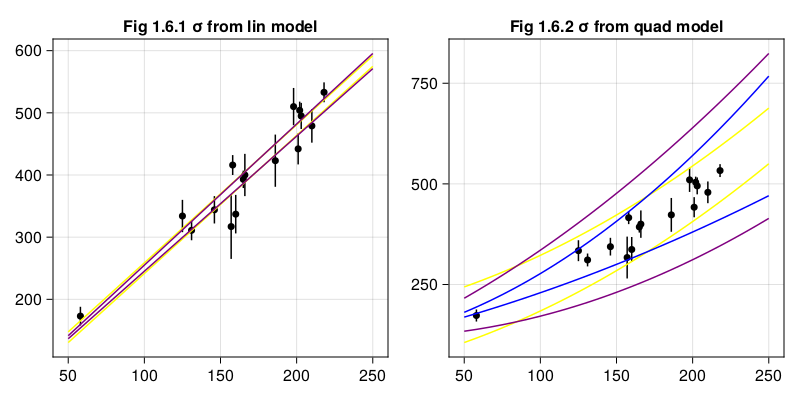

In [17]:
f = Figure(resolution=(800,400))
xx = LinRange(50, 250, 25)

Axis(f[1, 1], title ="Fig 1.6.1 σ from lin model")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize = 10, color = :black)
lines!(xx, (B_mean_lin_jack .+ B_std_lin_jack) .+ M_mean_lin_jack .* xx , color=:yellow)
lines!(xx, (B_mean_lin_jack .- B_std_lin_jack) .+ M_mean_lin_jack .* xx , color=:yellow)
lines!(xx, B_mean_lin_jack .+ (M_mean_lin_jack .+ M_std_lin_jack) .* xx , color=:purple)
lines!(xx, B_mean_lin_jack .+ (M_mean_lin_jack .- M_std_lin_jack) .* xx , color=:purple)

Axis(f[1, 2], title ="Fig 1.6.2 σ from quad model")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize = 10, color = :black)
lines!(xx, (B_mean_quad_jack .+ B_std_quad_jack) .+ M_mean_quad_jack .* xx .+ Q_mean_quad_jack .* xx .^2, color=:yellow)
lines!(xx, (B_mean_quad_jack .- B_std_quad_jack) .+ M_mean_quad_jack .* xx .+ Q_mean_quad_jack .* xx .^2, color=:yellow)
lines!(xx, B_mean_quad_jack .+ (M_mean_quad_jack .+ M_std_quad_jack) .* xx .+ Q_mean_quad_jack .* xx .^2, color=:purple)
lines!(xx, B_mean_quad_jack .+ (M_mean_quad_jack .- M_std_quad_jack) .* xx .+ Q_mean_quad_jack .* xx .^2, color=:purple)
lines!(xx, B_mean_quad_jack .+ M_mean_quad_jack  .* xx .+ (Q_mean_quad_jack .+ Q_std_quad_jack) .* xx .^2, color=:blue)
lines!(xx, B_mean_quad_jack .+ M_mean_quad_jack  .* xx .+ (Q_mean_quad_jack .- Q_std_quad_jack) .* xx .^2, color=:blue)

f

Clearly, the linear model is more consistant with the data set. We don't need q to improve data fitting in this data set.  

<div class="alert alert-block alert-success">
    
<b>Conclusion:</b> In term of minimum cost function to find the best fit of parameters to the data, the quadratic model can reach lower than the linear one. However, only the minimum cost function, we cannot conclude it is better. In fact, we can also generalize the higher order model, like 10, and then intuitively the higher order would reach the lower cost functin because they can fit all the data we have. This leads to "the over-fitting problem" which we need regularization to deal with it. 

<b>Outlook:</b>  We can try generate data by the quadratic model adding some noise and then try data fitting again to find the best model.   
</div>

### Stretch 1. Other criterias for testing model

1. Chi-squre

What is Chi-squre?

\begin{equation}
\chi^2=\sum_i\frac{(y_i-y^{pred}_i)^2}{y^{pred}_i}
\end{equation}

A chi-square (χ2) is a measure of the difference between the observed and model. Then, high is bad. Let's apply to result and see the result from both model

In [18]:
#The example of cost function for quadratic fiiting
function Chi_square_lin(parameters, data) #sigma included
    b = parameters[1]
    m = parameters[2]
    x = data.x
    y = data.y
    sigma = data.sigma_y
    y_pred = b .+ m .* x 
    return sum((y .- y_pred).^2 / y_pred)
end;
#The example of cost function for quadratic fiiting
function Chi_square_quad(parameters, data) #sigma included
    b = parameters[1]
    m = parameters[2]
    q = parameters[3]
    x = data.x
    y = data.y
    sigma = data.sigma_y
    y_pred = b .+ m .* x .+ q.* x.^2
    return sum((y .- y_pred).^2 / y_pred)
end;

In [19]:
params = [50., 2., 0.]
println("χ₁ = ", Chi_square_lin(Min(Costlin_gauss,params,data),data), "\nχ₂ = ", Chi_square_quad(Min(Costquad_gauss,params,data),data)) 


χ₁ = 31.29922714129151
χ₂ = 28.6486638644977


We can see that quad-model $\chi_{2}$ lower than lin-model $\chi_{1}$ which mean the quad model can improve the fitiing if we using this criteria.

2. Akaike Information Criterion

a numerical implementation of Occam's Razor that is supposed to tell you whether you are justified in adding the quadratic parameter to your model. The smaller the AIC value, the better the model fit.
\begin{equation}
AIC = 2K-2\ln{L}
\end{equation}

where $K$ is parameters and $L$ is the maximum likelihood.


In [20]:
println("AIC for liner-model = ", 2*2+2*mincost_gauss,"\nAIC for quad-model = ",2*3+2*mincost_quad )

AIC for liner-model = 2092.851022750748
AIC for quad-model = 2094.012544495923


Oh! Now, we can see that AIC for lin-model is lower that quad-model!!! which mean the quad model can doesn't improve the fitiing if we using this criteria. This criteria satisfy with our Jackknife analysis.

3. Bayesian Information Criterion (BIC)

\begin{equation}
BIC = k\ln{n}-2\ln{L}
\end{equation}

where $k$ is parameters, $n$ is the number of data points, and $L$ is the maximum likelihood.

In [21]:
println("BIC for liner-model = ",2*log(16)+2*mincost_gauss, "\nBIC for quad-model = ", 3*log(16)+2*mincost_quad)

BIC for liner-model = 2094.3962001952277
BIC for quad-model = 2096.330310662642


***

## (Q2) Investigating the m, b plane
<div class="alert alert-block alert-info">
<b>In this section, we will make contour plots of cost function. We will look contour plots from the following cases:</b> 
<br>  
</div>  

1. single data point and combined data points
2. all data + outlier-rejecting version of cost function

### Single & combined point
We begin with the first case to observe the contour plot of a data point and how it change.

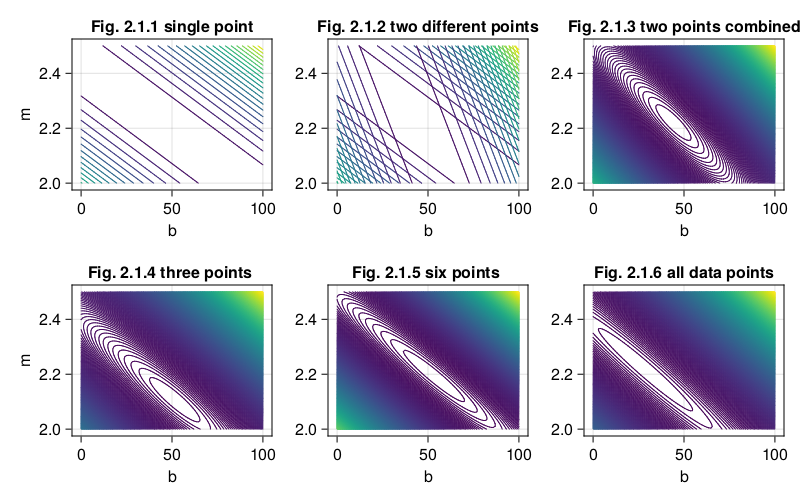

In [22]:
# Range of m,b values to plot
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

f = Figure(resolution=(800,500))


Axis(f[1, 1], xlabel = "b", ylabel ="m", title = "Fig. 2.1.1 single point")
point = data[1,:]
# Compute the objective function for each point in a grid
og = [Costlin_gauss([b,m], point ) for b in bvals, m in mvals] 
f2 = contour!(bvals, mvals, og, levels=20)

Axis(f[1, 2], xlabel = "b", title = "Fig. 2.1.2 two different points")
contour!(bvals, mvals, og, levels=20)
point = data[2,:]
# Compute the objective function for another point in a grid
og = [Costlin_gauss([b,m], point) for b in bvals, m in mvals]
contour!(bvals, mvals, og, levels=20)

Axis(f[1, 3], xlabel = "b", title = "Fig. 2.1.3 two points combined")
point = data[1:2,:]
# Compute the objective function for combined point in a grid
og = [Costlin_gauss([b,m], point) for b in bvals, m in mvals]
f1 = contour!(bvals, mvals, og, levels=400)
#Colorbar(f[1, 4],f1)

Axis(f[2, 1], xlabel = "b", ylabel ="m", title = "Fig. 2.1.4 three points ")
point = data[1:3,:]
# Compute the objective function for each point in a grid
og = [Costlin_gauss([b,m], point ) for b in bvals, m in mvals] 
f2 = contour!(bvals, mvals, og, levels=400)

Axis(f[2, 2], xlabel = "b", title = "Fig. 2.1.5 six points ")
point = data[1:6,:]
# Compute the objective function for another point in a grid
og = [Costlin_gauss([b,m], point) for b in bvals, m in mvals]
contour!(bvals, mvals, og, levels=400)

Axis(f[2, 3], xlabel = "b", title = "Fig. 2.1.6 all data points")
point = data
# Compute the objective function for combined point in a grid
og = [Costlin_gauss([b,m], point) for b in bvals, m in mvals]
f1 = contour!(bvals, mvals, og, levels=400)
#Colorbar(f[2, 4],f1)

f

Fig. 2.1.1 show that contour plot has many way to fit the data which it is make sense because there is just a single point. Next, we add the another point to see the different contour line in the same plot in Fig. 2.1.2 When we have more data the parameter space now is constrained as shown in Fig. 2.1.3, 2.1.4, 2.1.5 and 2.1.6


### All data point with abnormal data points & outlier-rejecting version of cost function
We will the abnormal data to our orginal data and propose the modified cost function to recover the best fit to global trend by ruling out the abnormal points.

In [23]:
#Plot of Linear vs Quadratic models
f = Figure(resolution=(500,500))
xx = LinRange(0, 300, 25)
data = alldata[5:end,:]
Axis(f[1, 1], title = "Fig. 2.2 adding abnormal data points", xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y, color = :gray)
scatter!(data.x, data.y, markersize = 10, color = :black, label ="old")
adddata = alldata[1:4,:]
scatter!(adddata.x, adddata.y, markersize = 10, color = :blue, label ="new")
errorbars!(adddata.x, adddata.y, adddata.sigma_y, color = :gray)
b_lin, m_lin, mincost_lin = Min(Costlin_gauss,params, data)
lines!(xx, b_lin .+ m_lin .* xx, color=:red, label = "old best-fit", linestyle = :dashed)
b_0, m_0 = 50., 2.;
params = [b_0,m_0]
b_lin_2, m_lin_2, mincost_lin_2 = Min(Costlin_gauss, params, alldata)
lines!(xx, b_lin_2 .+ m_lin_2 .* xx, color=:blue, label = "new best-fit", linestyle = :dashed)
axislegend(position = :rb, patchsize = (15,15))
f

Not same as before, when we encounter `alldata` minimized Gaussian negative log-likelihood dont give us the "good" result because we have some data point that too deviate from the trend. 

In this situation, one way can heal is introducing modified likelihood for cost function to reduce the influence of the abnormal-data points.

In [24]:
function Costlin_outliers(parameters, data)
    b = parameters[1]
    m = parameters[2]
    
    x = data.x
    y = data.y
    sigma = data.sigma_y
    frac_bad = 1e-2
    like_bad = frac_bad * (1. / 600.)

    y_pred = b .+ m .* x
    like_good = (1. - frac_bad) * 1 ./(sqrt(2*π) .* sigma) .* exp.(-0.5 * (y .- y_pred).^2 ./ sigma.^2)
    like = like_bad .+ like_good
    #like =  1 ./(sqrt(2*π) .* sigma) .* exp.(-0.5 * (y .- y_pred).^2 ./ sigma.^2)
    loglike = log.(like)

    return -sum(loglike)
end;

- Let's investigate the contour plot of using the old cost function and the new one.

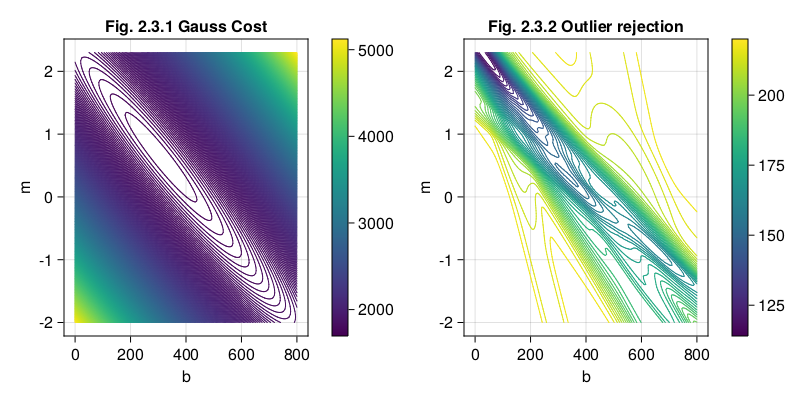

In [25]:
# Range of m,b values to plot
bvals = LinRange(0, 800., 200)
mvals = LinRange(-2, 2.3, 100);
f = Figure(resolution=(800,400))
Axis(f[1, 1], xlabel = "b", ylabel ="m", title = "Fig. 2.3.1 Gauss Cost")
point = alldata
og = [Costlin_gauss([b,m], point)
      for b in bvals, m in mvals]
f1 = contour!(bvals, mvals, og, levels=400)
Colorbar(f[1, 2],f1)
# Compute the objective function for each point in a grid
og = [Costlin_outliers([b,m], alldata)
      for b in bvals, m in mvals]
Axis(f[1, 3], xlabel = "b", ylabel ="m", title = "Fig. 2.3.2 Outlier rejection")
f1 = contour!(bvals, mvals, og, levels=40)
Colorbar(f[1, 4],f1)
f

<div class="alert alert-block alert-warning">
<b>Warning:</b> By using this cost function, the contour will change. It can be stuck at local minima if we start at some initial points. We can notice 3 minima in Fig 2.3.2, the first one is the global minima at the up-left corner around (b,m)=(2,0) and 2 local minima at the center a around (b,m)=(300,0) and the down-right around (b,m)=(600,-1). If we start near the local minima, It will get stuck at there.
</div>

- Let's compare the best fit from global and local minimas

In [26]:
#Global
b_0,m_0 = 50.,2.
b_gauss, m_gauss = Min(Costlin_gauss, [b_0,m_0], alldata)
b_out, m_out = Min(Costlin_outliers, [b_0,m_0], alldata)
#Local1
b_punk, m_punk = Min(Costlin_outliers, [600.,-1.], alldata)
#Local2
b_npunk, m_npunk = Min(Costlin_outliers, [300.,0], alldata);

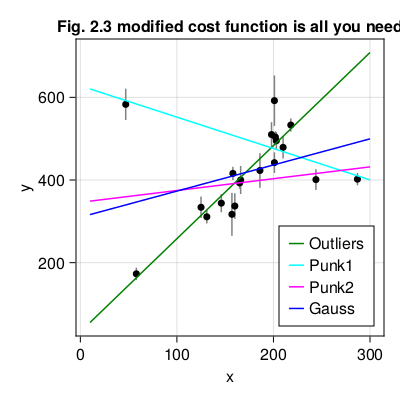

In [27]:
f = Figure(resolution=(400,400))
xx = LinRange(10, 300, 25)
Axis(f[1, 1], title = "Fig. 2.3 modified cost function is all you need", xlabel = "x", ylabel = "y")
errorbars!(alldata.x, alldata.y, alldata.sigma_y, color = :gray)
scatter!(alldata.x, alldata.y, markersize = 10, color = :black)
lines!(xx, b_out .+ m_out .* xx , color=:green, label = "Outliers")
lines!(xx, b_punk .+ m_punk .* xx , color=:cyan, label = "Punk1")
lines!(xx, b_npunk .+ m_npunk .* xx , color=:magenta, label = "Punk2")
lines!(xx, b_gauss .+ m_gauss .* xx, color=:blue, label = "Gauss")
axislegend(position = :rb, patchsize = (15,15))
f

<div class="alert alert-block alert-success">
<b>Conclusion:</b> the cost function is more constrainted when we have more data points. However, if there are some abnormal data included in our data set due to the rare noise or fail measurement, Gaussian cost function doesn't give us the good fitting anymore. We then need to modified the cost function (Outliers) to be able to reject the abnormal data by reducing the influnce from those data. We can see that from Fig. 2.3 The outliers perform beeter that the original cost function (Gauss). However, if we initialize guess near the local minima, it can be stuck in local minima (Punk1, Punk2).
</div>


### Stretch 2. Investigating Optimization Path

In [28]:
M = []
B = []
function Cost_record(parameters, data)
  b = parameters[1]
  m = parameters[2]
  push!(M, m)
  push!(B, b)
  x = data.x
  y = data.y
  sigma = data.sigma_y
  y_pred = b .+ m .* x
  return -sum(-log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end
M = []
B = []
function Cost_record_outliers(parameters, data)
  b = parameters[1]
  m = parameters[2]
  push!(M, m)
  push!(B, b)
  x = data.x
  y = data.y
  sigma = data.sigma_y
  frac_bad = 1e-2
  like_bad = frac_bad * (1. / 600.)

  y_pred = b .+ m .* x
  like_good = (1. - frac_bad) * 1 ./(sqrt(2*π) .* sigma) .* exp.(-0.5 * (y .- y_pred).^2 ./ sigma.^2)
  like = like_bad .+ like_good
  #like =  1 ./(sqrt(2*π) .* sigma) .* exp.(-0.5 * (y .- y_pred).^2 ./ sigma.^2)
  loglike = log.(like)
  return -sum(loglike)
end;

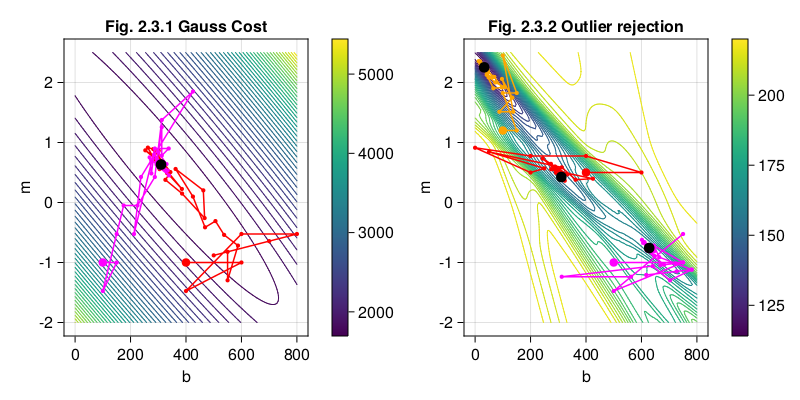

In [29]:
# Range of m,b values to plot
M = []
B = []
bvals = LinRange(0, 800., 200)
mvals = LinRange(-2, 2.5, 100);
f = Figure(resolution=(800,400))
Axis(f[1, 1], xlabel = "b", ylabel ="m", title = "Fig. 2.3.1 Gauss Cost")
point = alldata
og = [Costlin_gauss([b,m], point)
      for b in bvals, m in mvals]
f1 = contour!(bvals, mvals, og, levels=40)
#initial gauss
b_0, m_0 = [400.,-1.]
optimize(p -> Cost_record(p, point), [b_0,m_0])
M = Float64.(M)
B = Float64.(B);

plot!(B,M, color= :red, markersize = 6,alpha =0)
scatter!(B[1], M[1],color= :red)
lines!(B,M, color =:red,alpha = 0.01)
scatter!(B[end], M[end], color= :black, markersize = 15)

M = []
B = []
b_0, m_0 = [100.,-1.]
optimize(p -> Cost_record(p, point), [b_0,m_0])
M = Float64.(M)
B = Float64.(B);

plot!(B,M, color= :magenta, markersize = 6,alpha =0)
scatter!(B[1], M[1],color= :magenta)
lines!(B,M, color =:magenta)
scatter!(B[end], M[end], color= :black, markersize = 15)
M = []
B = []
Colorbar(f[1, 2],f1)
# Compute the objective function for each point in a grid
og = [Costlin_outliers([b,m], alldata)
      for b in bvals, m in mvals]
Axis(f[1, 3], xlabel = "b", ylabel ="m", title = "Fig. 2.3.2 Outlier rejection")
f1 = contour!(bvals, mvals, og, levels=30)

b_0, m_0 = [500.,-1.]
optimize(p -> Cost_record_outliers(p, point), [b_0,m_0])
M = Float64.(M)
B = Float64.(B);
plot!(B,M, color= :magenta, markersize = 6)
scatter!(B[1], M[1],color= :magenta)
lines!(B,M, color =:magenta)
scatter!(B[end], M[end],color= :black, markersize = 15)
M = []
B = []
b_0, m_0 = [400.,0.5]
optimize(p -> Cost_record_outliers(p, point), [b_0,m_0])
M = Float64.(M)
B = Float64.(B);
plot!(B,M, color= :red, markersize = 6)
scatter!(B[1], M[1],color= :red)
lines!(B,M, color =:red)
scatter!(B[end], M[end],color= :black, markersize = 15)
M = []
B = []
b_0, m_0 = [100.,1.2]
optimize(p -> Cost_record_outliers(p, point), [b_0,m_0])
M = Float64.(M)
B = Float64.(B);
plot!(B,M, color= :orange, markersize = 6)
scatter!(B[1], M[1],color= :orange)
lines!(B,M, color =:orange)
scatter!(B[end], M[end],color= :black, markersize = 15)

Colorbar(f[1, 4],f1)

f

***

## (Q3) Line parameterization

<div class="alert alert-block alert-info">
<b>In this section, we will try to reparametize the equation for aline that the variables are less correlated.</b> 
<br>  
</div> 

- Let's try substracting the mean of x from all x
\begin{equation}
\{x\}_{i=5}^{20}\rightarrow\{x-\bar{x}\}_{i=5}^{20}
\end{equation}

From [Fig. 1.1.5 in subsection 1.1.4](#F1.5.1), we have investigate the B&M scatter plot. We notice that they are anti-correlated. 


In [30]:
println(" covarince of b&m = ", cov(Blin_jack, Mlin_jack))

 covarince of b&m = -0.4343911941537293


In [31]:
#create new data set
newdata_x = alldata.x[5:end] .- mean(alldata.x[5:end]);
newdata = DataFrame(x=newdata_x, y=alldata.y[5:end], sigma_y=alldata.sigma_y[5:end]);

In [32]:
initial_lin = [50.,2.]
params = [50.,2.,0] #linear model use 2 params
b_gauss, m_gauss, mincost_lin = Min(Costlin_gauss,initial_lin, newdata);

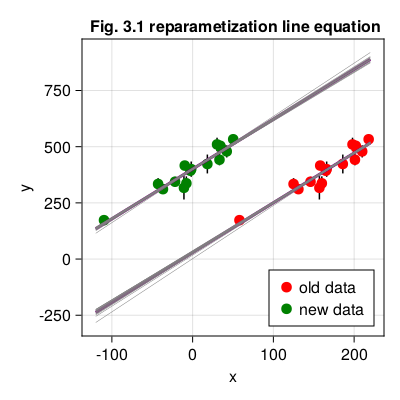

In [33]:
f = Figure(resolution=(400,400))

#axislegend(position = :rb, patchsize = (15,15))
Axis(f[1, 1], title =" Fig. 3.1 reparametization line equation", xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=15, color=:red, label="old data")
xx = LinRange(-120,220,100)
b_gauss, m_gauss, mincost_lin = Min(Costlin_gauss,initial_lin, data)
yy_lin = xx .* m_gauss .+ b_gauss
lines!(xx, yy_lin, color=:purple, linewidth=3)

B_jack, M_jack = JK(Costlin_gauss, data, params)
for i in 1:ndata
    yy_jack =  xx .* M_jack[i] .+ B_jack[i]
    lines!(xx, yy_jack,linewidth=0.5, color=:gray)
end
errorbars!(newdata.x, newdata.y, newdata.sigma_y)
scatter!(newdata.x, newdata.y, markersize=15, color=:green, label="new data")
#xx = LinRange(-150,100,100)
b_gauss, m_gauss, mincost_lin = Min(Costlin_gauss,initial_lin, newdata)
yy_lin = xx .* m_gauss .+ b_gauss
lines!(xx, yy_lin, color=:purple, linewidth=3)

B_jack, M_jack = JK(Costlin_gauss, newdata, params)
for i in 1:ndata
    yy_jack = xx .* M_jack[i] .+ B_jack[i]
    lines!(xx, yy_jack,linewidth=0.5, color=:gray)
end
axislegend(position = :rb, patchsize = (15,15))
f

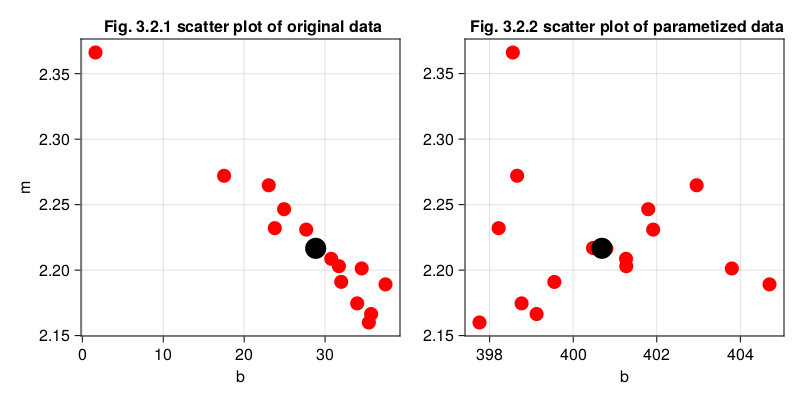

In [34]:
B_jack, M_jack = JK(Costlin_gauss, data, params)
ndata = size(data,1)

f = Figure(resolution = (800,400))
Axis(f[1, 1], title =" Fig. 3.2.1 scatter plot of original data", xlabel = "b", ylabel = "m")
scatter!(B_jack, M_jack, markersize=20, color=:red)

b_gauss, m_gauss = Min(Costlin_gauss, [b_0,m_0], data)
plot!([b_gauss], [m_gauss], markersize=30)

data = alldata[5:end, :]

B_jack_new, M_jack_new = JK(Costlin_gauss, newdata, params)
ndata = size(data,1)

Axis(f[1, 2], title =" Fig. 3.2.2 scatter plot of parametized data", xlabel = "b")
scatter!(B_jack_new, M_jack_new, markersize=20, color=:red)

b_gauss, m_gauss = Min(Costlin_gauss, [b_0,m_0], newdata)
plot!([b_gauss], [m_gauss], markersize=30)
#plot!([mean(B_jack_new)], [mean(M_jack_new)], color = :blue, markersize=30)

f

We can see that the new data give us variables less correlated.

In [35]:
cov(Blin_jack,Mlin_jack), cov(B_jack_new, M_jack_new)

(-0.4343911941537293, -0.007973171730983606)

We will check the consistent of B&M by convert the result from new data to original data. 

From $\hat{y}_i=b_{old}+m_{old}x$, and $\hat{y}_i=b_{new}+m_{new}(x-\bar{x}))$, so

\begin{equation}
m_{old} = m_{new}, \\
m_{old} = b_{new}-m_{old}\bar{x}
\end{equation}

Check m and b from new and old

In [36]:
isless(M_jack-M_jack_new, [1e-3]) 

true

In [37]:
isless(.- M_jack .* mean(alldata.x[5:end]).- B_jack.+B_jack_new, [1e-3])

true

They are close by tolerance 1e-3

<div class="alert alert-block alert-success">
    
<b>Conclusion:</b> We can get less correlated variables by parametization (shifting the all data x by the mean. 

<b>Outlook:</b>  We can try to find the other parametization which is better than the provied method.
</div>

*** 

## Appendix A Higher-order fitting

Other example: 4th order fitting model. You can easily check that this model is very sensitive to initial paramerters.

In [38]:
function Costhigh_gauss(params, data) #sigma included
    b = params[1]
    m = params[2]
    q = params[3]
    r = params[4]
    s = params[5]
    #t = params[6]
    #u = params[7]
    x = data.x
    y = data.y
    sigma = data.sigma_y
    y_pred = b .+ m .* x .+ q .* x.^2. .+ r .* x.^3 .+ s .* x.^4
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end;

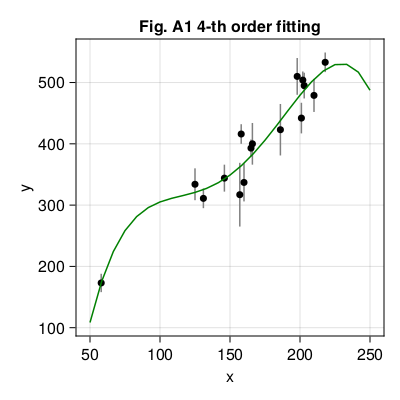

In [39]:
#initializer
b_0, m_0, q_0, r_0, s_0 = 50., 2., 0., 0., 0. 
#intial_lin = [b_0, m_0] #linear model use 2 params
initial_high = [b_0, m_0, q_0, r_0, s_0] #quadrtic use 3 params

#Optimal value from 2 types model
#b_lin, m_lin, mincost_lin = Min(Costlin_gauss,initial_lin,data) #linear model
b_high, m_high, q_high, r_high, s_high, mincost_high = Min(Costhigh_gauss, initial_high, data) #quadratic model

#Plot of Linear vs Quadratic models
f = Figure(resolution=(400,400))
xx = LinRange(50, 250, 25)
Axis(f[1, 1], title = "Fig. A1 4-th order fitting", xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y, color = :gray)
scatter!(data.x, data.y, markersize = 10, color = :black)
lines!(xx, b_high .+ m_high .* xx .+ q_high .* xx .^2 .+ r_high .* xx .^3 .+ s_high .* xx.^4, color=:green, label = "quad-model")
#lines!(xx, b_lin .+ m_lin .* xx, color=:red, label = "lin-model")
#axislegend(position = :rb, patchsize = (15,15))
f

In [40]:
Costdiff(mincost_high, MCQ1) #new low!

-0.39679384994565225

***

<div class="alert alert-block alert-success">
    
    <b><center>END OF THE NOTEBOOK</center> </b> <center> Have a nice day! :) </center>
</div> 